# Credit Card Detection

Neste projeto iremos realizar detecção de fraudes em cartões de crédito. Os dados podem ser obtidos no dataset do kaggle: [Credit Card Fraud](https://www.kaggle.com/mlg-ulb/creditcardfraud)

# Importando dados e bibliotecas

## Importando principais bibliotecas e os dados

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
# Importando dados
dataset = pd.read_csv('creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Variáveis
feature_names = list(dataset.columns)
n_features = len(feature_names)

# Nomes das variáveis
features_string = ""
for i in range(n_features):
  if (i+1)%5>0:
    features_string += feature_names[i] + '\t'
  else:
    features_string += feature_names[i] + '\n'
print(features_string)

Time	V1	V2	V3	V4
V5	V6	V7	V8	V9
V10	V11	V12	V13	V14
V15	V16	V17	V18	V19
V20	V21	V22	V23	V24
V25	V26	V27	V28	Amount
Class	


O conjunto de dados representa a descrição de transações de cartão de crédito.

As variáveis de V1 até V28 representam as componentes principais das transações, que neste caso são utilizadas para codificar dados sensíveis. Enquanto isso as variáveis Time e Amount representam o instante desde a primeira transação e a quantia requisitada na transação. 

Por fim a variável Class descreve se a transação correspondentes são fraude ou não.

# Verificando distribuição das variáveis

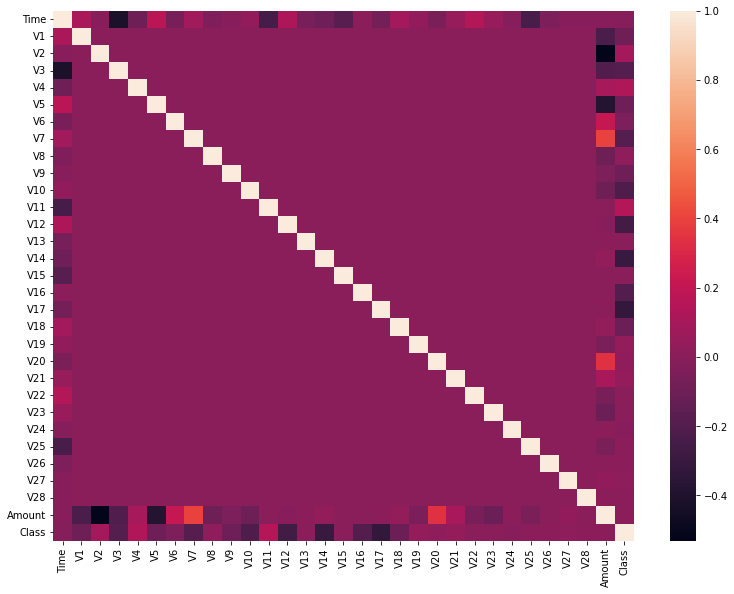

In [4]:
# Verificando as correlações
fig = plt.figure(figsize=(6.5*2,6.5*1.5))
sns.heatmap(dataset.corr())
fig.savefig('figures/correlation.pdf', bbox_inches='tight')
fig.savefig('figures/correlation.png', bbox_inches='tight')
plt.show()

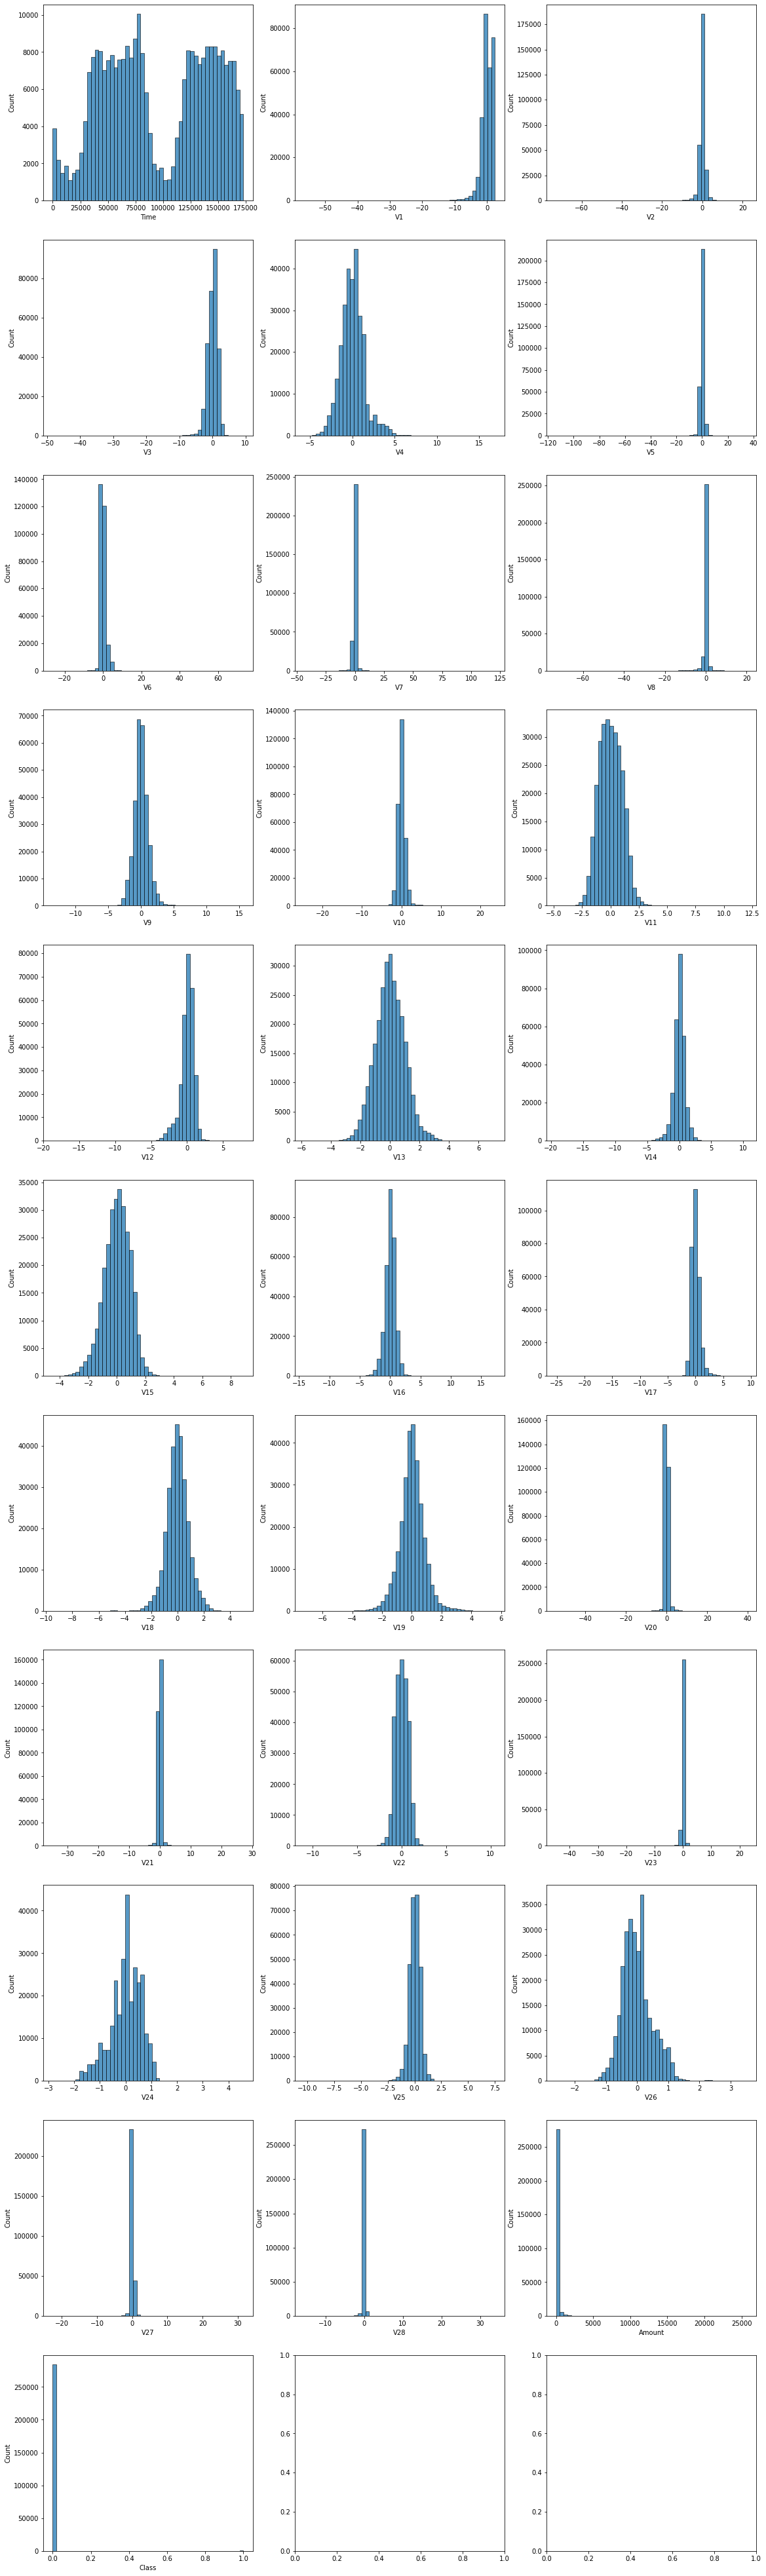

In [5]:
# Número de colunas e linhas para plotagem em grade
ncols = 3
nrows = ((n_features)//ncols) + 1 if (n_features)%ncols>0 else ((n_features)//ncols)


# Plotando histograma
fig,axes = plt.subplots(nrows=nrows,ncols=ncols)
fig.set_size_inches(6.5*ncols,6.5*nrows)

axes = axes.ravel()

for i in range(n_features):
    ax = axes[i]
    sns.histplot(data=dataset,x=feature_names[i],ax=ax,bins=50)

fig.savefig('figures/hist_table.pdf', bbox_inches='tight')
fig.savefig('figures/hist_table.png', bbox_inches='tight')
plt.show()

Vemos uma distribuição quase normal nas variáveis V1 até V28, o que é esperado de uma decomposição em componentes principais.

Na variável Time não vemos uma distribuição bastante clara, mas aparentemente é relacionado com os ciclos diários, pois cada dia tem 86400 segundos, aproximadamente igual ao dos ciclos definidos pela distribuição das transações. Além disso, mantém uma quantidade quase uniforme de transações por intervalo durante grande parte do dia.

Na variável Amount vemos uma distribuição bastante concentrada em valores abaixo de 1000, porém com caudas longas de distribuição.


Vemos também um forte desbalanceamento entre as classes. Para resolver esse problema iremos realizar um rebalanceamento.

Além disso, o banco de dados possui entre 250.000 e 300.000. Nesse caso, um modelo de vizinhança provavelmente não será indicado. Outros modelos devem ter seu tamanho reduzido para facilitar o treinamento ou modelos que não utilizem todo o conjunto de dados simultaneamente.

Vamos ajustar o tempo em termos de hora do dia, em relação ao início da contagem do tempo e vamos verificar se há um padrão de horas em que há mais fraudes.

Também vamos verificar a quantidade de dinheiro realizada em fraudes.

In [6]:
dataset["Time"] = dataset["Time"].apply(lambda x:(x/3600)%24)

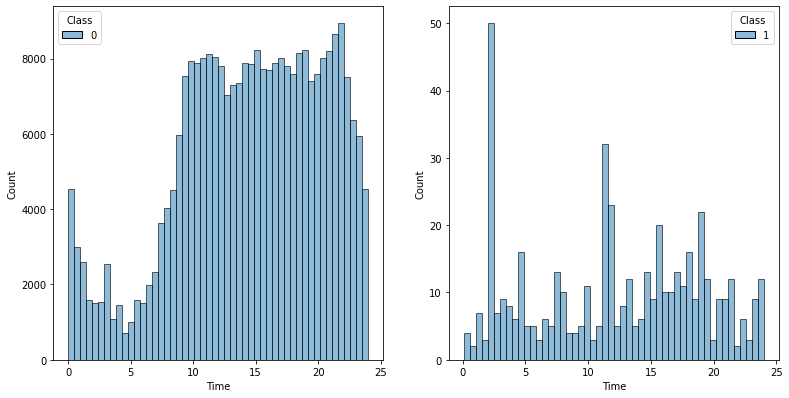

In [7]:
fig,axes = plt.subplots(1,2)
fig.set_size_inches(6.5*2,6.5*1)

axes = axes.ravel()

name = "Time"

ax = axes[0]
sns.histplot(data=dataset[dataset["Class"] == 0],x=name,hue="Class",ax=ax,bins=50)



ax = axes[1]
sns.histplot(data=dataset[dataset["Class"] == 1],x=name,hue="Class",ax=ax,bins=50)

fig.savefig('figures/time_hist.pdf', bbox_inches='tight')
fig.savefig('figures/time_hist.png', bbox_inches='tight')
plt.show()

Vemos fraudes bastante distribuídas pelo dia, com picos por volta da segunda hora, que aparentemente é o horário com início da queda da atividade das transações. 

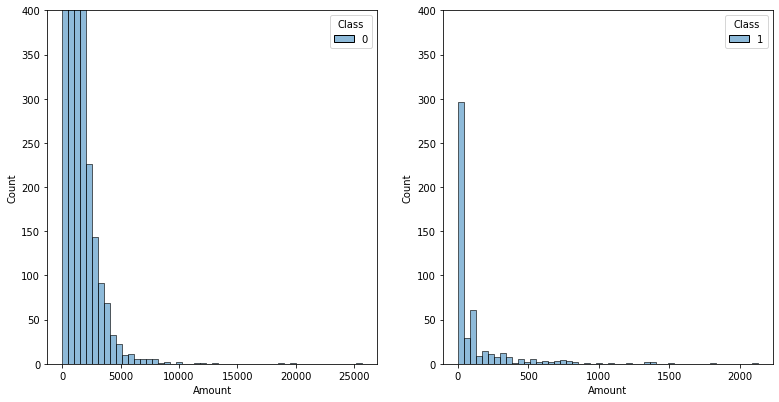

In [8]:
fig,axes = plt.subplots(1,2)
fig.set_size_inches(6.5*2,6.5*1)

axes = axes.ravel()

name = "Amount"

ax = axes[0]
sns.histplot(data=dataset[dataset["Class"] == 0],x=name,hue="Class",ax=ax,bins=50)
ax.set_ylim(0,400)


ax = axes[1]
sns.histplot(data=dataset[dataset["Class"] == 1],x=name,hue="Class",ax=ax,bins=50)
ax.set_ylim(0,400)
fig.savefig('figures/amount_hist.pdf', bbox_inches='tight')
fig.savefig('figures/amount_hist.png', bbox_inches='tight')
plt.show()

O valor das transações fraudulentas em geral são abaixo de 500 e não ultrapassaram 3000. Por outro lado, as transações normais tem um limite maior, com no máximo 25000 e mais comum abaixo de 5000.

## Balanceando os dados e amostragem estratificada

Aqui realizamos uma amostragem estratificada através do método SMOTE e em seguida balanceamos as classes.

A divisão de treino, teste e validação foi de 60%, 20% e 20%, respectivamente.

Realizaremos a reamostragem somente da classe minoritária e além disso a amostragem dos dados de treino e validação serão treinados separadamente nos objetos ``sm_train`` e ``sm_val`` derivados da classe ``SMOTE`` do pacote ``imblearn.over_sampling``.

In [9]:
from imblearn.over_sampling import SMOTE



# Armazenando em numpy array's os dados
X = dataset.values[:,:-1]
y = dataset.values[:,-1:]



# Número de exemplos
n_examples = len(y)


# Separando os dados de não-fraude e os de fraude
# nf significa não-fraude
X_nf = X[y.reshape(-1) == 0,:]
y_nf = y[y.ravel() == 0]
n_examples_nf = len(y_nf)

# Embaralhando os dados
np.random.seed(43)
index_shuffling_nf = list(range(n_examples_nf))
np.random.shuffle(index_shuffling_nf)
np.random.seed(None)

X_nf,y_nf = X_nf[index_shuffling_nf,:],y_nf[index_shuffling_nf,:]


# Definindo os tamanhos dos dados de treino, teste e validação para não-fraude
# A divisão ficará 60%-20%-20%
train_size_nf = int(n_examples_nf*0.6)
val_size_nf = int(n_examples_nf*0.2)
test_size_nf = n_examples_nf - train_size_nf - val_size_nf


# Separando em dados de treino-teste-validação
X_nf_train,y_nf_train = X_nf[:train_size_nf],y_nf[:train_size_nf]
X_nf_val,y_nf_val = X_nf[train_size_nf:train_size_nf+val_size_nf],y_nf[train_size_nf:train_size_nf+val_size_nf]
X_nf_test,y_nf_test = X_nf[train_size_nf+val_size_nf:],y_nf[train_size_nf+val_size_nf:]




# Separando os dados de não-fraude e os de fraude
# f significa fraude
X_f = X[y.reshape(-1) == 1,:]
y_f = y[y.ravel() == 1]
n_examples_f = len(y_f)


# Embaralhando os dados
np.random.seed(42)
index_shuffling_f = list(range(n_examples_f))
np.random.shuffle(index_shuffling_f)
np.random.seed(None)

X_f,y_f = X_f[index_shuffling_f,:],y_f[index_shuffling_f,:]


# Definindo os tamanhos dos dados de treino, teste e validação para fraude
# A divisão ficará 60%-20%-20%
train_size_f = int(n_examples_f*0.6)
val_size_f = int(n_examples_f*0.2)
test_size_f = n_examples_f - train_size_f - val_size_f


# Separando em dados de treino-teste-validação
X_f_train,y_f_train = X_f[:train_size_f],y_f[:train_size_f]
X_f_val,y_f_val = X_f[train_size_f:train_size_f+val_size_f],y_f[train_size_f:train_size_f+val_size_f]
X_f_test,y_f_test = X_f[train_size_f+val_size_f:],y_f[train_size_f+val_size_f:]




# Concatenando os dados rebalanceados

X_train = np.concatenate((X_f_train,X_nf_train),axis=0)
y_train = np.concatenate((y_f_train,y_nf_train),axis=0)


X_val = np.concatenate((X_f_val,X_nf_val),axis=0)
y_val = np.concatenate((y_f_val,y_nf_val),axis=0)


X_test = np.concatenate((X_nf_test,X_f_test),axis=0)
y_test = np.concatenate((y_nf_test,y_f_test),axis=0)




# Rebalanceando os dados de treino e validação
sm_train = SMOTE(sampling_strategy='minority',random_state=42)
sm_val = SMOTE(sampling_strategy='minority',random_state=42)

X_train,y_train = sm_train.fit_resample(X_train,y_train)
X_val,y_val = sm_val.fit_resample(X_val,y_val)

# Definindo os tamanhos de treino, teste e validação novamente
train_size = len(y_train)
val_size = len(y_val)
test_size = len(y_test)
n_examples = train_size + val_size + test_size 

# Embaralhando novamente os dados de treino e validação
np.random.seed(101)
index_shuffling_train = list(range(train_size))
np.random.shuffle(index_shuffling_train)
np.random.seed(None)

X_train,y_train = X_train[index_shuffling_train],y_train[index_shuffling_train]


np.random.seed(101)
index_shuffling_val = list(range(val_size))
np.random.shuffle(index_shuffling_val)
np.random.seed(None)

X_val,y_val = X_val[index_shuffling_val],y_val[index_shuffling_val]


# Testando Modelos de Aprendizagem Não-Supervisionada

Iremos testar modelos simples de apredizagem não-supervisionada, isso terá dois propósitos:

* Primeiramente estes métodos servirão como um benchmark (desempenho a ser melhorado).

* Segundo, a escolha de limiar (threshold) realizada nestes métodos pode ser utilizada também nos modelos de apredizado supervisionado.

## Testando K-Means

O objetivo do modelo K-Means é separar os dados que não são fraude em clusters e em seguida encontrar um limiar de corte para a distância até o centro do cluster, para detectar as anomalias. 

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Mudança de escala para facilitar o treinamento e tornar os dados mais estáveis
# No caso do KNN também ajuda na previsão de classes, visto variáveis diferentes provavelmente tem escalas diferentes
sc_X = MinMaxScaler()

#
X_train_sc = sc_X.fit_transform(X_train)
X_val_sc = sc_X.transform(X_val)
X_test_sc = sc_X.transform(X_test)
X_nf_train_sc = sc_X.transform(X_nf_train)

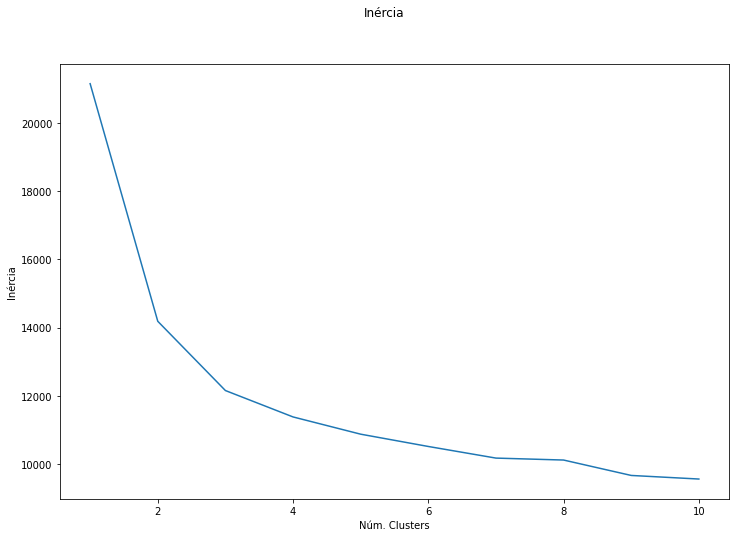

In [11]:
from sklearn.cluster import MiniBatchKMeans

# hiperparametros K-means
n_clusters_max=10
batch_size=10000
max_iter=300

wscc_total = np.zeros(n_clusters_max)
num_clusters = np.arange(1,n_clusters_max+1,dtype=int)
for i in range(n_clusters_max):
    kmeans_clusters = MiniBatchKMeans(n_clusters=num_clusters[i],init='k-means++',random_state=42,batch_size=batch_size,max_iter=max_iter)
    # Treinamento K-Means
    kmeans_clusters.fit(X_nf_train_sc)
    wscc_total[i] = kmeans_clusters.inertia_
plt.figure(figsize=(12,8))
plt.plot(num_clusters,wscc_total)
plt.suptitle("Inércia")
plt.xlabel('Núm. Clusters')
plt.ylabel('Inércia')
fig.savefig('figures/elbow_kmeans.pdf', bbox_inches='tight')
fig.savefig('figures/elbow_kmeans.png', bbox_inches='tight')
plt.show()

Utilizaremos ``n_clusters = 3``, ou seja, dois clusters para aplicar o método K-means

In [12]:
kmeans_clusters = MiniBatchKMeans(n_clusters=3,init='k-means++',random_state=42,batch_size=batch_size,max_iter=max_iter)
# Treinamento K-Means
kmeans_clusters.fit(X_nf_train_sc)

MiniBatchKMeans(batch_size=10000, max_iter=300, n_clusters=3, random_state=42)

Função para calcular os quadrados das distâncias até o cluster mais próximo

In [13]:
def cluster_squared_distance(X):
    # Centro do Cluster
    c = kmeans_clusters.cluster_centers_
    # Cluster mais próximo
    clusters = kmeans_clusters.predict(X)
    # Calculando distâncias
    distances = np.linalg.norm(X-c[clusters],axis=1)**2
    return distances


val_prob = cluster_squared_distance(X_val_sc)

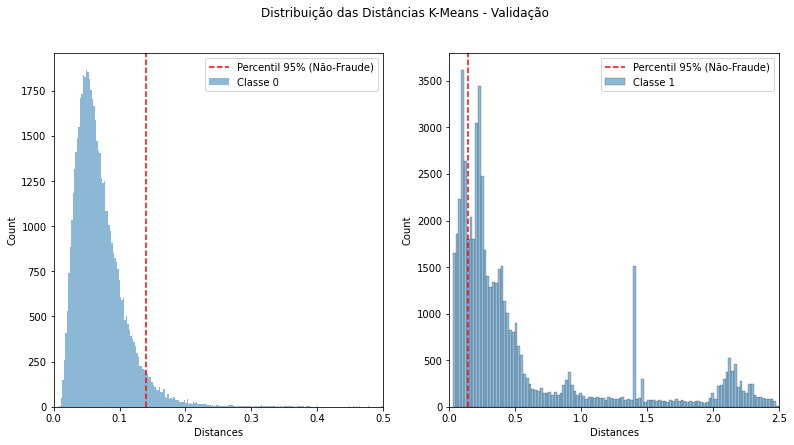

In [14]:
# Distâncias Até o Cluster mais próximo (Não-Fraude)
val_prob_nf = cluster_squared_distance(X_val_sc[y_val == 0,:])
data_nf = np.concatenate((val_prob_nf,np.zeros_like(val_prob_nf)))
data_nf = data_nf.reshape((-1,2),order="F")


# Distâncias Até o Cluster mais próximo (Fraude)
val_prob_f = cluster_squared_distance(X_val_sc[y_val == 1,:])
data_f = np.concatenate((val_prob_f,np.ones_like(val_prob_f)))
data_f = data_f.reshape((-1,2),order="F")


# Concatenando dados em um dataframe
data = pd.DataFrame(np.concatenate([data_nf,data_f]),columns=["Distances","Class"])


fig,axes = plt.subplots(1,2)
fig.set_size_inches(6.5*2,6.5*1)

axes = axes.ravel()

# Plotando distancias quadradas por classe
ax = axes[0]
sns.histplot(data=data[data["Class"] == 0], x="Distances", hue="Class", ax=ax, legend=False)
ax.axvline(data[data["Class"] == 0]["Distances"].quantile(0.95), c="r", ls="--")
ax.set_xlim([0,0.5])
ax.legend(labels=["Percentil 95% (Não-Fraude)","Classe 0"])


ax = axes[1]
sns.histplot(data=data[data["Class"] == 1], x="Distances", hue="Class", ax=ax)
ax.axvline(data[data["Class"] == 0]["Distances"].quantile(0.95), c="r", ls="--")
ax.set_xlim([0,2.5])
ax.legend(labels=["Percentil 95% (Não-Fraude)","Classe 1"])


fig.suptitle("Distribuição das Distâncias K-Means - Validação")
fig.savefig('figures/distances_hist_kmeans.pdf', bbox_inches='tight')
fig.savefig('figures/distances_hist_kmeans.png', bbox_inches='tight')
plt.show()

### Testando diferentes limiares (thresholds)

Definindo alguns testes e decidindo o melhor limiar (threshold) para prever as classes.

Referências: 

[A Gentle Introduction to Threshold-Moving for Imbalanced Classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

[Optimal Threshold for Imbalanced Classification](https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293)



#### G-Mean

O método G-Mean encontra a limiar maximizando a média geométrica entre a taxa de verdadeiros positivos e a taxa de verdadeiros negativos.

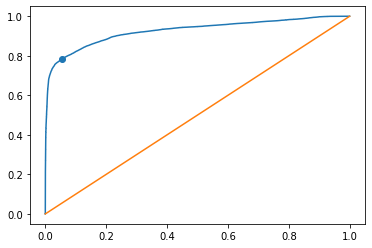

Best Threshold: 0.1358
Area Under the Curve: 0.9261


In [15]:
from sklearn.metrics import roc_curve

# Utilizando a ROC curve para encontrar os fpr (taxa de falsos positivos)
# e os tpr (taxa de verdadeiros positivos)
fpr, tpr, thresholds = roc_curve(y_val,val_prob)
x = [0,1]

# Taxa de verdadeiros negativos = 1-fpr (1-(taxa de falsos positivos))
j_max = np.sqrt(tpr*(1-fpr)).argmax()
threshold = thresholds[j_max]

# Verificando o ponto na curva ROC
plt.plot(fpr,tpr)
plt.plot(x,x)
plt.scatter((fpr[j_max]),tpr[j_max])
plt.show()
print('Best Threshold: %1.4f'%threshold)
print('Area Under the Curve: %1.4f'%(np.diff(fpr)*tpr[1:]).sum())

In [16]:
# Realizando as previsões para os dados de teste e validação
val_prob = cluster_squared_distance(X_val_sc)
y_val_pred_gmean = (val_prob>=threshold)


test_prob = cluster_squared_distance(X_test_sc)
y_test_pred_gmean = (test_prob>=threshold)

**************Dados de Validação**************

F-beta score: 0.8115 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.815113,0.944111,0.874883,56863.000000
1.0,0.933604,0.785854,0.853381,56863.000000
accuracy,0.864983,0.864983,0.864983,0.864983
macro avg,0.874358,0.864983,0.864132,113726.000000
weighted avg,0.874358,0.864983,0.864132,113726.000000


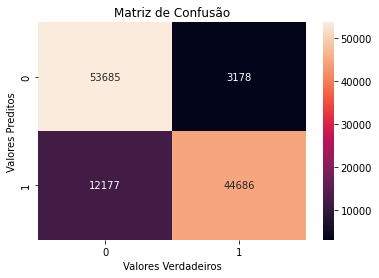

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score

# Utilizando as métricas Fbeta, classification report e confusion matrix para verificar as precisão das previsões
print("**************Dados de Validação**************\n")
beta = 2

print("F-beta score: %1.4f"%fbeta_score(y_val.reshape(-1),y_val_pred_gmean,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_val.reshape(-1),y_val_pred_gmean,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_val.reshape(-1),y_val_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

**************Dados de Teste**************

F-beta score: 0.1194 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.999721,0.946591,0.972431,56863.00000
1.0,0.026914,0.848485,0.052174,99.00000
accuracy,0.946420,0.946420,0.946420,0.94642
macro avg,0.513318,0.897538,0.512302,56962.00000
weighted avg,0.998031,0.946420,0.970832,56962.00000


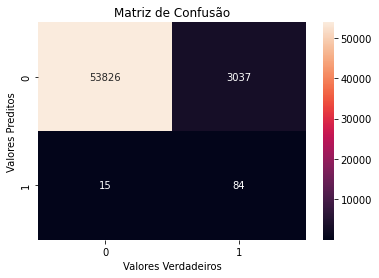

In [18]:
print("**************Dados de Teste**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_test.reshape(-1),y_test_pred_gmean,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_test.reshape(-1),y_test_pred_gmean,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

#### $F_{\beta}$

O método $F_{\beta}$ encontra a limiar maximizando a quantidade $F_{\beta}$.

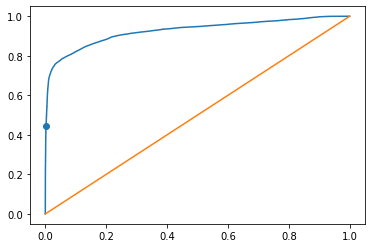

Best Threshold: 0.3341
Area Under the Curve: 0.9261


In [19]:
from sklearn.metrics import recall_score

# Utilizando a ROC curve para encontrar os fpr (taxa de falsos positivos)
# e os tpr (taxa de verdadeiros positivos)
fpr, tpr, thresholds = roc_curve(y_val,val_prob)
x = [0,1]

n_thresholds = 50
np.random.seed(42)
random_thresholds = np.random.rand(n_thresholds)*(val_prob.max() - val_prob.min()) + val_prob.min()
np.random.seed(None)

# Neste caso vamos maximizar o f-beta com beta = 2
beta = 2
fbeta_scores = np.zeros((n_thresholds))
for j in range(n_thresholds):
  y_val_pred = (val_prob>=random_thresholds[j])
  fbeta_scores[j] = fbeta_score(y_val,y_val_pred,beta=beta)


# Encontrando o limiar com maior valor de fbeta
j_max = fbeta_scores.argmax()

threshold = random_thresholds[j_max]


y_val_pred = (val_prob>=threshold)
tpr_max = recall_score(y_val,y_val_pred)
fpr_max = 1 - recall_score(y_val,y_val_pred,pos_label=0)


# Verificando o ponto na curva ROC
plt.plot(fpr,tpr)
plt.plot(x,x)
plt.scatter(fpr_max,tpr_max)
plt.show()
print('Best Threshold: %1.4f'%threshold)
print('Area Under the Curve: %1.4f'%(np.diff(fpr)*tpr[1:]).sum())

In [20]:
# Realizando as previsões para o limiar encontrado
val_prob = cluster_squared_distance(X_val_sc)
y_val_pred_fbeta = (val_prob>=threshold)


test_prob = cluster_squared_distance(X_test_sc)
y_test_pred_fbeta = (test_prob>=threshold)

**************Dados de Validação**************

F-beta score: 0.5014 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.643010,0.997608,0.781988,56863.000000
1.0,0.994668,0.446142,0.615992,56863.000000
accuracy,0.721875,0.721875,0.721875,0.721875
macro avg,0.818839,0.721875,0.698990,113726.000000
weighted avg,0.818839,0.721875,0.698990,113726.000000


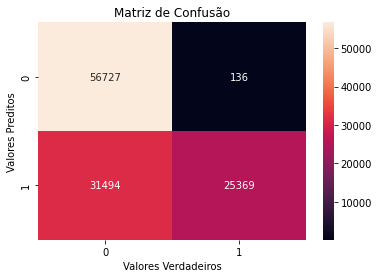

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Realizando as avaliações dos resultados obtidos
print("**************Dados de Validação**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_val.reshape(-1),y_val_pred_fbeta,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_val.reshape(-1),y_val_pred_fbeta,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_val.reshape(-1),y_val_pred_fbeta,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

**************Dados de Teste**************

F-beta score: 0.5232 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.999331,0.997784,0.998557,56863.000000
1.0,0.326203,0.616162,0.426573,99.000000
accuracy,0.997121,0.997121,0.997121,0.997121
macro avg,0.662767,0.806973,0.712565,56962.000000
weighted avg,0.998161,0.997121,0.997563,56962.000000


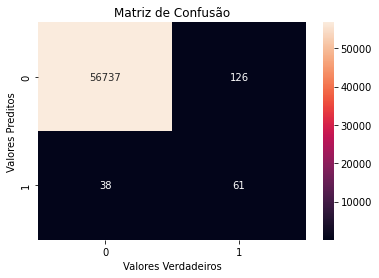

In [22]:
print("**************Dados de Teste**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_test.reshape(-1),y_test_pred_fbeta,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_test.reshape(-1),y_test_pred_fbeta,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_fbeta,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

Aqui podemos notar que encontrar os parâmetros através do $F_{\beta}$ com $\beta = 2$ pode induzir um alto erro na previsão dos casos. Aparentemente G-Mean parece ser a métrica mais indicada para o nosso problema.

#### Percentil

Neste método calculamos o a percentil 95 das distâncias até o cluster nos dados de validação que não são fraude e predizemos como fraude os valores que se encontrar acima deste valor.

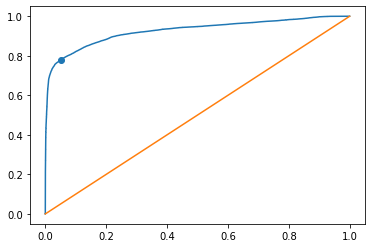

Best Threshold: 0.1398
Area Under the Curve: 0.9261


In [23]:
val_prob_nf = cluster_squared_distance(X_val_sc[y_val == 0,:])
data_nf = np.concatenate((val_prob_nf,np.zeros_like(val_prob_nf)))
data_nf = data_nf.reshape((-1,2),order="F")
val_prob_f = cluster_squared_distance(X_val_sc[y_val == 1,:])
data_f = np.concatenate((val_prob_f,np.ones_like(val_prob_f)))
data_f = data_f.reshape((-1,2),order="F")
data = pd.DataFrame(np.concatenate([data_nf,data_f]),columns=["Distances","Class"])

threshold = np.quantile(val_prob_nf,.95)


y_val_pred = (val_prob>=threshold)
tpr_max = recall_score(y_val,y_val_pred)
fpr_max = 1 - recall_score(y_val,y_val_pred,pos_label=0)


# Verificando o ponto na curva ROC
plt.plot(fpr,tpr)
plt.plot(x,x)
plt.scatter(fpr_max,tpr_max)
plt.show()
print('Best Threshold: %1.4f'%threshold)
print('Area Under the Curve: %1.4f'%(np.diff(fpr)*tpr[1:]).sum())

In [24]:
# Realizando as previsões para o limiar encontrado
val_prob = cluster_squared_distance(X_val_sc)
y_val_pred_std = (val_prob>=threshold)


test_prob = cluster_squared_distance(X_test_sc)
y_test_pred_std = (test_prob>=threshold)

**************Dados de Validação**************

F-beta score: 0.8055 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.810415,0.949985,0.874667,56863.000000
1.0,0.939579,0.777764,0.851048,56863.000000
accuracy,0.863875,0.863875,0.863875,0.863875
macro avg,0.874997,0.863875,0.862858,113726.000000
weighted avg,0.874997,0.863875,0.862858,113726.000000


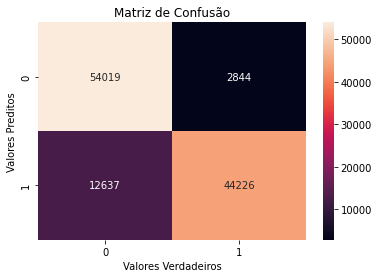

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Realizando as avaliações dos resultados obtidos
print("**************Dados de Validação**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_val.reshape(-1),y_val_pred_std,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_val.reshape(-1),y_val_pred_std,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_val.reshape(-1),y_val_pred_std,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

**************Dados de Teste**************

F-beta score: 0.1319 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.999723,0.952447,0.975513,56863.000000
1.0,0.030129,0.848485,0.058192,99.000000
accuracy,0.952266,0.952266,0.952266,0.952266
macro avg,0.514926,0.900466,0.516852,56962.000000
weighted avg,0.998038,0.952266,0.973918,56962.000000


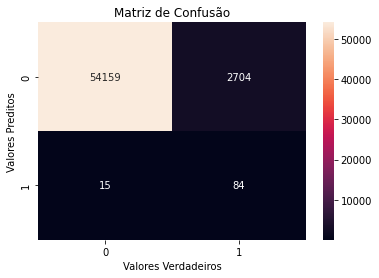

In [26]:
print("**************Dados de Teste**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_test.reshape(-1),y_test_pred_std,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_test.reshape(-1),y_test_pred_std,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_std,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

### Conclusões para K-Means

*************************   Dados de Teste   *************************


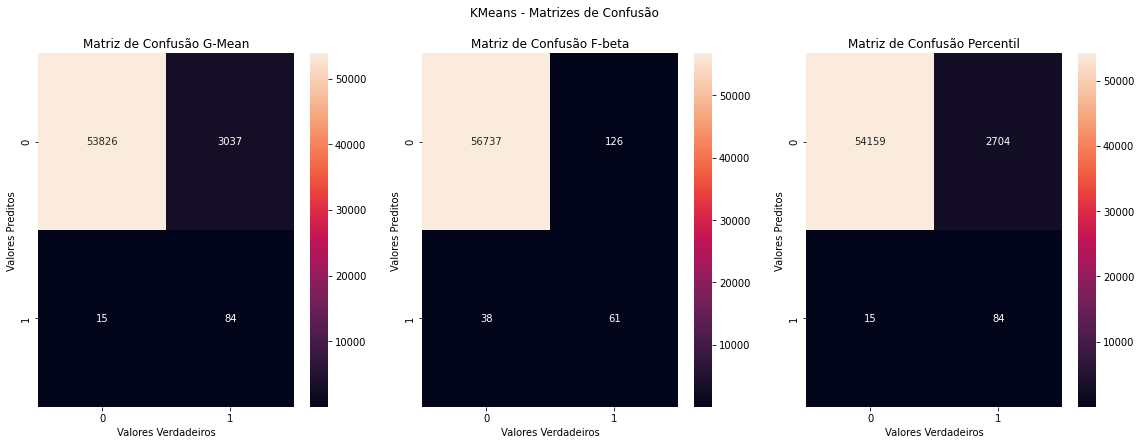

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import json

num_asterisk = 25
print("*"*num_asterisk + "   Dados de Teste   " + "*"*num_asterisk)


fig,axes = plt.subplots(1,3)
fig.set_size_inches(6.5*3,6.5*1)

# G-mean
ax = axes[0]
sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f',ax=ax)
ax.set_title('Matriz de Confusão G-Mean')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')




# F-beta
ax = axes[1]
sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_fbeta,labels=[0.,1.]),annot=True,fmt='1.0f',ax=ax)
ax.set_title('Matriz de Confusão F-beta')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')



# Percentil
ax = axes[2]
sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_std,labels=[0.,1.]),annot=True,fmt='1.0f',ax=ax)
ax.set_title('Matriz de Confusão Percentil')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')

fig.suptitle("KMeans - Matrizes de Confusão")


AUC_ROC = roc_auc_score(y_test,test_prob)


average_precision = average_precision_score(y_test,test_prob)




performance = {"AUC ROC":AUC_ROC,"Average Precision": average_precision,
                "Classification Report G-Mean":classification_report(y_test.reshape(-1),y_test_pred_gmean,digits=2,output_dict=True),
                "Classification Report F-Beta":classification_report(y_test.reshape(-1),y_test_pred_fbeta,digits=2,output_dict=True),
                "Classification Report Percentil":classification_report(y_test.reshape(-1),y_test_pred_std,digits=2,output_dict=True)}
with open("performance/performance_kmeans.json","w",encoding="utf-8") as f:
    json.dump(performance,f)


fig.savefig('figures/confusion_matrix_kmeans.pdf', bbox_inches='tight')
fig.savefig('figures/confusion_matrix_kmeans.png', bbox_inches='tight')
plt.show()

Aparentemente a melhor métrica para avaliar o limiar é o Percentil.

Na realidade o número de falsos positivos é bastante sensível ao limiar, para aumentar em uma unidade o número fraudes preditas corretamente (verdadeiros positivos), abrimos mão de muitas transações que serão avaliadas incorretamente. Ou seja, com o modelo utilizado, para evitar que uma transação a mais seja fraudada, eventualmente devemos bloquear diversas transações, nesse caso devemos ver qual é o melhor resultado.

## Testando IsolationForest

IsolationForest é um algoritmo que detecta outliers, que nesse caso iremos testar para verificar se esse algoritmo nos dá bons resultados na classificação de fraudes.

Para ter um treino mais rápido, foi utilizado um truque de treinamento de florestas aleatórias com ``warm_start`` para treinar separadamente diferentes amostras do conjunto de dados, acelerando o treinamento. 

Referências: 

[Documentação Oficial Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

[How to Fit Random Forests Faster](https://towardsdatascience.com/how-to-fit-random-forests-faster-a837de51d376)

Iremos selecionar o hiperparâmetro ``max_features`` calculando o melhor limiar com o método G-Mean e validando o melhor desempenho da métrica $F_{\beta}$.

In [28]:
from sklearn.ensemble import IsolationForest

# n_splits é a subdivisão de dados para treinamento de uma parte da floresta aleatória
n_splits = 5

# Embaralhando dados
np.random.seed(101)
idx = np.array(range(len(X_nf_train_sc)))
np.random.shuffle(idx)
splits = np.array_split(idx,n_splits)
np.random.seed(None)

# Hiperparâmetros
max_features = list(range(3,9))
Gmean = []
Fbeta_scores = []
best_thresholds = []
for n_features in max_features:
  # IsolationForest com warm_start e treinamento de cada subdivisão (split) dos dados de treino
  clf = IsolationForest(n_estimators=0,max_features=n_features,warm_start=True,random_state=42,n_jobs=-1)
  k = 1
  # Treinando cada split
  for idx in splits:
    # Definindo 100 árvores de decisão para cada split dos dados de treino
    clf.set_params(n_estimators=k*100)
    clf.fit(X_nf_train_sc[idx])
    k += 1
  # Definindo o score de anomalia para os dados de validação
  val_prob = -clf.score_samples(X_val_sc)

  # Utilizando o G-Mean para encontrar o melhor limiar de cada hiperparâmetro
  fpr, tpr, thresholds = roc_curve(y_val,val_prob)

  j_max = np.sqrt(tpr*(1-fpr)).argmax()
  Gmean.append(np.sqrt(tpr*(1-fpr)).max())
  threshold = thresholds[j_max]
  best_thresholds.append(threshold)

  y_val_pred = (val_prob>=threshold)
  beta = 2
  Fbeta_scores.append(fbeta_score(y_val.reshape(-1),y_val_pred,beta=beta))

  print('Max Features: %d,\t Threshold: %1.3f,\t G-Mean:%1.3f,\t fbeta: %1.3f,\t beta = %1.2f'%(n_features,threshold,Gmean[-1],Fbeta_scores[-1],beta))
j_max = np.argmax(Fbeta_scores)
max_feature = max_features[j_max]
print("best max_features F-beta:%d"%max_feature)

Max Features: 3,	 Threshold: 0.468,	 G-Mean:0.879,	 fbeta: 0.860,	 beta = 2.00
Max Features: 4,	 Threshold: 0.473,	 G-Mean:0.883,	 fbeta: 0.857,	 beta = 2.00
Max Features: 5,	 Threshold: 0.458,	 G-Mean:0.883,	 fbeta: 0.877,	 beta = 2.00
Max Features: 6,	 Threshold: 0.462,	 G-Mean:0.883,	 fbeta: 0.864,	 beta = 2.00
Max Features: 7,	 Threshold: 0.465,	 G-Mean:0.885,	 fbeta: 0.864,	 beta = 2.00
Max Features: 8,	 Threshold: 0.455,	 G-Mean:0.893,	 fbeta: 0.891,	 beta = 2.00
best max_features F-beta:8


Utilizaremos ``max_features=8``, o maior valor obtido para $F_{\beta}$ para o limiar gerado pelo método G-Mean.

In [29]:
clf = IsolationForest(n_estimators=0,max_features=max_feature,warm_start=True,random_state=42,n_jobs=-1)

# Repetindo o procedimento que utilizamos para encontrar os melhores hiperparâmetros
n_splits = 5

np.random.seed(101)
idx = np.array(range(len(X_nf_train_sc)))
np.random.shuffle(idx)
splits = np.array_split(idx,n_splits)
np.random.seed(None)


k = 1
for idx in splits:
    clf.set_params(n_estimators=k*100)
    clf.fit(X_nf_train_sc[idx])
    k += 1

# Prevendo os scores de anomalia dos dados de validação e teste
val_prob = -clf.score_samples(X_val_sc)
test_prob = -clf.score_samples(X_test_sc)





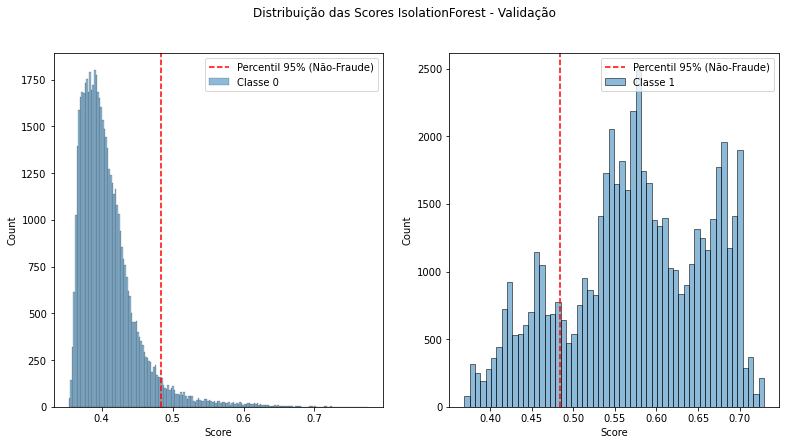

In [30]:
# Score (Não-Fraude)
val_prob_nf = -clf.score_samples(X_val_sc[y_val == 0,:])
data_nf = np.concatenate((val_prob_nf,np.zeros_like(val_prob_nf)))
data_nf = data_nf.reshape((-1,2),order="F")


# Score (Fraude)
val_prob_f = -clf.score_samples(X_val_sc[y_val == 1,:])
data_f = np.concatenate((val_prob_f,np.ones_like(val_prob_f)))
data_f = data_f.reshape((-1,2),order="F")


# Concatenando dados em um dataframe
data = pd.DataFrame(np.concatenate([data_nf,data_f]),columns=["Score","Class"])

fig,axes = plt.subplots(1,2)
fig.set_size_inches(6.5*2,6.5*1)

axes = axes.ravel()

# Plotando distancias quadradas por classe
ax = axes[0]
sns.histplot(data=data[data["Class"] == 0], x="Score", hue="Class", ax=ax, legend=False)
ax.axvline(data[data["Class"] == 0]["Score"].quantile(0.95), c="r", ls="--")
ax.legend(labels=["Percentil 95% (Não-Fraude)","Classe 0"])


ax = axes[1]
sns.histplot(data=data[data["Class"] == 1], x="Score", hue="Class", ax=ax)
ax.axvline(data[data["Class"] == 0]["Score"].quantile(0.95), c="r", ls="--")
ax.legend(labels=["Percentil 95% (Não-Fraude)","Classe 1"])


fig.suptitle("Distribuição das Scores IsolationForest - Validação")
fig.savefig('figures/scores_hist_isolationforest.pdf', bbox_inches='tight')
fig.savefig('figures/scores_hist_isolationforest.png', bbox_inches='tight')
plt.show()

### Testando diferentes limiares (thresholds)

Definindo alguns testes e decidindo o melhor limiar (threshold) para prever as classes.

Referências: 

[A Gentle Introduction to Threshold-Moving for Imbalanced Classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

[Optimal Threshold for Imbalanced Classification](https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293)



#### G-Mean

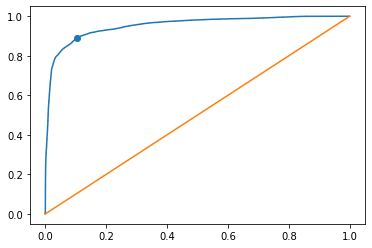

Best Threshold: 0.4548
Area Under the Curve: 0.9527


In [31]:
from sklearn.metrics import roc_curve

# Utilizando a ROC curve para encontrar os fpr (taxa de falsos positivos)
# e os tpr (taxa de verdadeiros positivos)
fpr, tpr, thresholds = roc_curve(y_val,val_prob)
x = [0,1]

# Taxa de verdadeiros negativos = 1-fpr (1-(taxa de falsos positivos))
j_max = np.sqrt(tpr*(1-fpr)).argmax()
threshold = thresholds[j_max]

# Verificando o ponto na curva ROC
plt.plot(fpr,tpr)
plt.plot(x,x)
plt.scatter((fpr[j_max]),tpr[j_max])
plt.show()
print('Best Threshold: %1.4f'%threshold)
print('Area Under the Curve: %1.4f'%(np.diff(fpr)*tpr[1:]).sum())

In [32]:
y_val_pred_gmean = (val_prob>=threshold)


y_test_pred_gmean = (test_prob>=threshold)

**************Dados de Validação**************

F-beta score: 0.8908 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.890421,0.895855,0.893130,56863.000000
1.0,0.895216,0.889753,0.892476,56863.000000
accuracy,0.892804,0.892804,0.892804,0.892804
macro avg,0.892818,0.892804,0.892803,113726.000000
weighted avg,0.892818,0.892804,0.892803,113726.000000


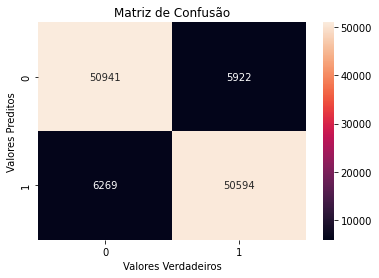

In [33]:
# Utilizando as métricas Fbeta, classification report e confusion matrix para verificar as precisão das previsões
print("**************Dados de Validação**************\n")
beta = 2

print("F-beta score: %1.4f"%fbeta_score(y_val.reshape(-1),y_val_pred_gmean,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_val.reshape(-1),y_val_pred_gmean,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_val.reshape(-1),y_val_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

**************Dados de Teste**************

F-beta score: 0.0680 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.999784,0.894694,0.944324,56863.000000
1.0,0.014483,0.888889,0.028502,99.000000
accuracy,0.894684,0.894684,0.894684,0.894684
macro avg,0.507134,0.891792,0.486413,56962.000000
weighted avg,0.998071,0.894684,0.942733,56962.000000


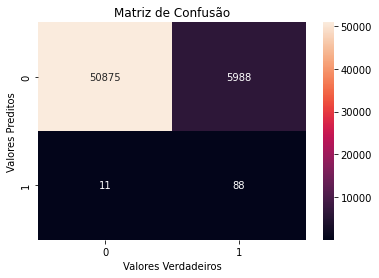

In [34]:
print("**************Dados de Teste**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_test.reshape(-1),y_test_pred_gmean,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_test.reshape(-1),y_test_pred_gmean,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

#### $F_{\beta}$

O método $F_{\beta}$ encontra a limiar maximizando a quantidade $F_{\beta}$.

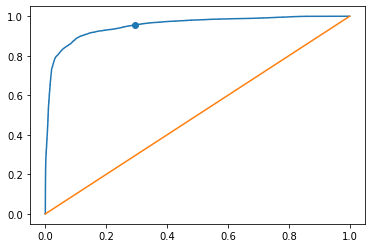

Best Threshold: 0.4193
Area Under the Curve: 0.9527


In [35]:
from sklearn.metrics import recall_score

# Utilizando a ROC curve para encontrar os fpr (taxa de falsos positivos)
# e os tpr (taxa de verdadeiros positivos)
fpr, tpr, thresholds = roc_curve(y_val,val_prob)
x = [0,1]

n_thresholds = 50
np.random.seed(42)
random_thresholds = np.random.rand(n_thresholds)*(val_prob.max() - val_prob.min()) + val_prob.min()
np.random.seed(None)

# Neste caso vamos maximizar o f-beta com beta = 2
beta = 2
fbeta_scores = np.zeros((n_thresholds))
for j in range(n_thresholds):
  y_val_pred = (val_prob>=random_thresholds[j])
  fbeta_scores[j] = fbeta_score(y_val,y_val_pred,beta=beta)


# Encontrando o limiar com maior valor de fbeta
j_max = fbeta_scores.argmax()

threshold = random_thresholds[j_max]


y_val_pred = (val_prob>=threshold)
tpr_max = recall_score(y_val,y_val_pred)
fpr_max = 1 - recall_score(y_val,y_val_pred,pos_label=0)


# Verificando o ponto na curva ROC
plt.plot(fpr,tpr)
plt.plot(x,x)
plt.scatter(fpr_max,tpr_max)
plt.show()
print('Best Threshold: %1.4f'%threshold)
print('Area Under the Curve: %1.4f'%(np.diff(fpr)*tpr[1:]).sum())

In [36]:
y_val_pred_fbeta = (val_prob>=threshold)


y_test_pred_fbeta = (test_prob>=threshold)

**************Dados de Validação**************

F-beta score: 0.9102 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.941021,0.705679,0.806532,56863.000000
1.0,0.764560,0.955771,0.849539,56863.000000
accuracy,0.830725,0.830725,0.830725,0.830725
macro avg,0.852790,0.830725,0.828036,113726.000000
weighted avg,0.852790,0.830725,0.828036,113726.000000


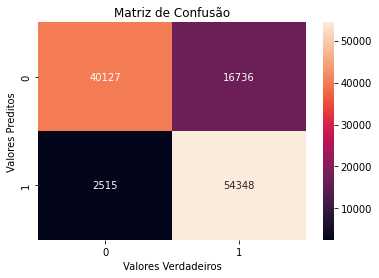

In [37]:
# Realizando as avaliações dos resultados obtidos
print("**************Dados de Validação**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_val.reshape(-1),y_val_pred_fbeta,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_val.reshape(-1),y_val_pred_fbeta,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_val.reshape(-1),y_val_pred_fbeta,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

**************Dados de Teste**************

F-beta score: 0.0264 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.999825,0.702495,0.825194,56863.00000
1.0,0.005409,0.929293,0.010755,99.00000
accuracy,0.702890,0.702890,0.702890,0.70289
macro avg,0.502617,0.815894,0.417975,56962.00000
weighted avg,0.998096,0.702890,0.823779,56962.00000


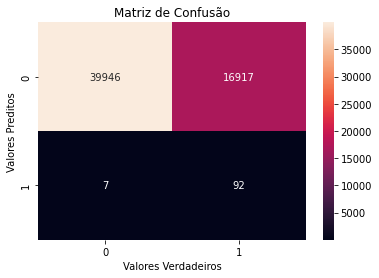

In [38]:
print("**************Dados de Teste**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_test.reshape(-1),y_test_pred_fbeta,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_test.reshape(-1),y_test_pred_fbeta,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_fbeta,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

#### Percentil

Neste método calculamos o a percentil 95 das distâncias até o cluster nos dados de validação que não são fraude e predizemos como fraude os valores que se encontrar acima deste valor.

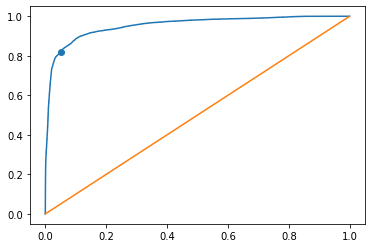

Best Threshold: 0.4842
Area Under the Curve: 0.9527


In [39]:
# Prevendo os scores de anomalia dos dados de validação (não fraudes)
val_prob_nf = -clf.score_samples(X_val_sc[y_val==0,:])

threshold = np.quantile(val_prob_nf,.95)


y_val_pred = (val_prob>=threshold)
tpr_max = recall_score(y_val,y_val_pred)
fpr_max = 1 - recall_score(y_val,y_val_pred,pos_label=0)


# Verificando o ponto na curva ROC
plt.plot(fpr,tpr)
plt.plot(x,x)
plt.scatter(fpr_max,tpr_max)
plt.show()
print('Best Threshold: %1.4f'%threshold)
print('Area Under the Curve: %1.4f'%(np.diff(fpr)*tpr[1:]).sum())

In [40]:
# Realizando as previsões para o limiar encontrado
y_val_pred_std = (val_prob>=threshold)


y_test_pred_std = (test_prob>=threshold)

**************Dados de Validação**************

F-beta score: 0.8426 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.841300,0.949985,0.892345,56863.000000
1.0,0.942565,0.820797,0.877477,56863.000000
accuracy,0.885391,0.885391,0.885391,0.885391
macro avg,0.891932,0.885391,0.884911,113726.000000
weighted avg,0.891932,0.885391,0.884911,113726.000000


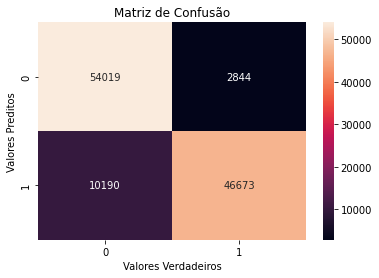

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Realizando as avaliações dos resultados obtidos
print("**************Dados de Validação**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_val.reshape(-1),y_val_pred_std,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_val.reshape(-1),y_val_pred_std,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_val.reshape(-1),y_val_pred_std,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

**************Dados de Teste**************

F-beta score: 0.1231 	 beta = 2.00


,precision,recall,f1-score,support
0.0,0.999704,0.949123,0.973757,56863.000000
1.0,0.027890,0.838384,0.053984,99.000000
accuracy,0.948931,0.948931,0.948931,0.948931
macro avg,0.513797,0.893754,0.513870,56962.000000
weighted avg,0.998015,0.948931,0.972159,56962.000000


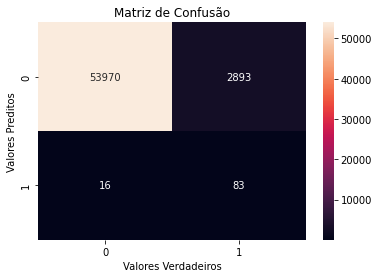

In [42]:
print("**************Dados de Teste**************\n")
beta = 2
print("F-beta score: %1.4f"%fbeta_score(y_test.reshape(-1),y_test_pred_std,beta=beta),'\t beta = %1.2f'%beta)

display(pd.DataFrame(classification_report(y_test.reshape(-1),y_test_pred_std,digits=2,output_dict=True)).T)

sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_std,labels=[0.,1.]),annot=True,fmt='1.0f')
ax = plt.gca()
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')
plt.show()

### Conclusões para IsolationForest

*************************   Dados de Teste   *************************


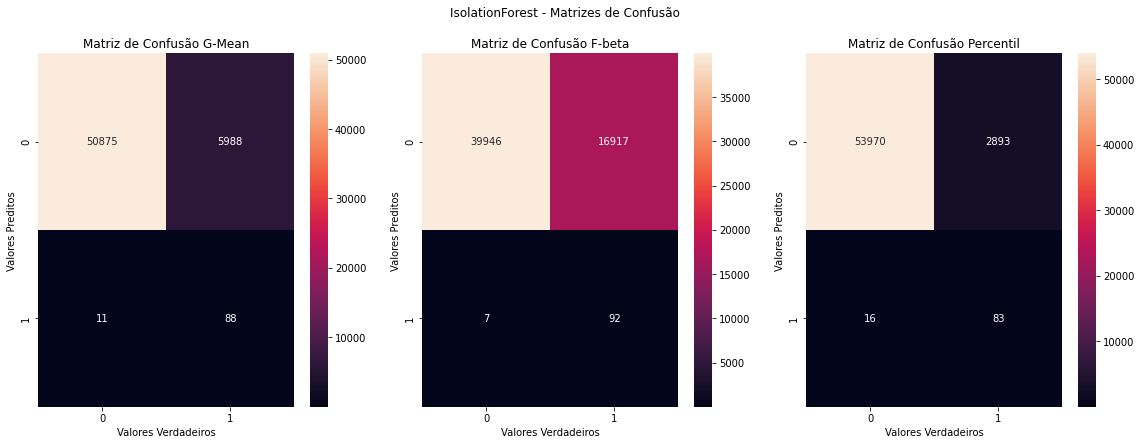

In [43]:
num_asterisk = 25
print("*"*num_asterisk + "   Dados de Teste   " + "*"*num_asterisk)


fig,axes = plt.subplots(1,3)
fig.set_size_inches(6.5*3,6.5*1)

# G-mean
ax = axes[0]
sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_gmean,labels=[0.,1.]),annot=True,fmt='1.0f',ax=ax)
ax.set_title('Matriz de Confusão G-Mean')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')




# F-beta
ax = axes[1]
sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_fbeta,labels=[0.,1.]),annot=True,fmt='1.0f',ax=ax)
ax.set_title('Matriz de Confusão F-beta')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')



# Percentil
ax = axes[2]
sns.heatmap(confusion_matrix(y_test.reshape(-1),y_test_pred_std,labels=[0.,1.]),annot=True,fmt='1.0f',ax=ax)
ax.set_title('Matriz de Confusão Percentil')
ax.set_xlabel('Valores Verdadeiros')
ax.set_ylabel('Valores Preditos')

fig.suptitle("IsolationForest - Matrizes de Confusão")

AUC_ROC = roc_auc_score(y_test,test_prob)


average_precision = average_precision_score(y_test,test_prob)


performance = {"AUC ROC":AUC_ROC,"Average Precision": average_precision,
                "Classification Report G-Mean":classification_report(y_test.reshape(-1),y_test_pred_gmean,digits=2,output_dict=True),
                "Classification Report F-Beta":classification_report(y_test.reshape(-1),y_test_pred_fbeta,digits=2,output_dict=True),
                "Classification Report Percentil":classification_report(y_test.reshape(-1),y_test_pred_std,digits=2,output_dict=True)}
with open("performance/performance_isolationforest.json","w",encoding="utf-8") as f:
    json.dump(performance,f)


fig.savefig('figures/confusion_matrix_isolationforest.pdf', bbox_inches='tight')
fig.savefig('figures/confusion_matrix_isolationforest.png', bbox_inches='tight')
plt.show()

Os resultados foram similares ao do método K-Means, servindo como baseline para os próximos testes.

# Conclusão

Nesta primeira parte nós utilizamos alguns métodos básicos de aprendizagem não-supervisionada, com o intuito de iniciar por modelos simples e fáceis de calibrar.

Na próxima parte iremos utilizar alguns métodos de aprendizagem supervisionada para avaliar se há uma vantagem competitiva de um tipo aprendizagem ou outro, para este problema especificamente.